In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Analysis of original data

In [229]:
# Load dataset
train_dir = "train.csv"

# Read the data
train_data = pd.read_csv(train_dir)

In [230]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient  

In [231]:
# Missing Values Analysis
print("\nMissing Values:")
print(train_data.isnull().sum())


Missing Values:
case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64


In [232]:
# Summary Statistics
print("\nSummary Statistics:")
print(train_data.describe())


Summary Statistics:
             case_id  Hospital_code  City_Code_Hospital  \
count  318438.000000  318438.000000       318438.000000   
mean   159219.500000      18.318841            4.771717   
std     91925.276848       8.633755            3.102535   
min         1.000000       1.000000            1.000000   
25%     79610.250000      11.000000            2.000000   
50%    159219.500000      19.000000            5.000000   
75%    238828.750000      26.000000            7.000000   
max    318438.000000      32.000000           13.000000   

       Available Extra Rooms in Hospital      Bed Grade      patientid  \
count                      318438.000000  318325.000000  318438.000000   
mean                            3.197627       2.625807   65747.579472   
std                             1.168171       0.873146   37979.936440   
min                             0.000000       1.000000       1.000000   
25%                             2.000000       2.000000   32847.000000   
50%

## Simple data cleaning (conversions and droppings)

In [233]:
# 4. Handling Missing Values
if 'Bed Grade' in train_data.columns and train_data['Bed Grade'].isnull().sum() > 0:
    train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
if 'City_Code_Patient' in train_data.columns and train_data['City_Code_Patient'].isnull().sum() > 0:
    train_data['City_Code_Patient'].fillna(train_data['City_Code_Patient'].mode()[0], inplace=True)

# Ensure Bed Grade and City Code are integers
if 'Bed Grade' in train_data.columns:
    train_data['Bed Grade'] = train_data['Bed Grade'].astype(int)
if 'City_Code_Patient' in train_data.columns:
    train_data['City_Code_Patient'] = train_data['City_Code_Patient'].astype(int)

/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_69793/1198924758.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_69793/1198924758.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [234]:
# Drop case_id and patientid
train_data.drop(columns=[col for col in ['case_id', 'patientid'] if col in train_data.columns], inplace=True)

In [235]:
# Handle 'Stay' column
stay_mapping = {
    '0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5,
    '51-60': 6, '61-70': 7, '71-80': 8, '81-90': 9, '91-100': 10,
    '100 Days': 10, 'More than 100 Days': 11
}
train_data['Stay'] = train_data['Stay'].map(stay_mapping)

In [236]:
# Convert categorical variables using the specified mappings
if 'Hospital_type_code' in train_data.columns:
    train_data['Hospital_type_code'] = train_data['Hospital_type_code'].map(lambda x: ord(x.lower()) - ord('a') + 1)
if 'Ward_Facility_Code' in train_data.columns:
    train_data['Ward_Facility_Code'] = train_data['Ward_Facility_Code'].map(lambda x: ord(x) - ord('A') + 1)
if 'Hospital_region_code' in train_data.columns:
    region_mapping = {'X': 1, 'Y': 2, 'Z': 3}
    train_data['Hospital_region_code'] = train_data['Hospital_region_code'].map(region_mapping)
if 'Ward_Type' in train_data.columns:
    train_data['Ward_Type'] = train_data['Ward_Type'].map(lambda x: ord(x) - ord('P') + 1)
if 'Type of Admission' in train_data.columns:
    admission_mapping = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
    train_data['Type of Admission'] = train_data['Type of Admission'].map(admission_mapping)
if 'Severity of Illness' in train_data.columns:
    severity_mapping = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}
    train_data['Severity of Illness'] = train_data['Severity of Illness'].map(severity_mapping)

In [237]:
label_encoders = {}

# Label Encode Age by decade
if 'Age' in train_data.columns:
    le = LabelEncoder()
    train_data['Age'] = le.fit_transform(train_data['Age'])
    label_encoders['Age'] = le

# Label Encode Department
if 'Department' in train_data.columns:
    le = LabelEncoder()
    train_data['Department'] = le.fit_transform(train_data['Department'])
    label_encoders['Department'] = le


In [238]:
# Convert categorical variables using the specified mappings
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient']
for col in categorical_codes:
    if col in train_data.columns:
        train_data[col] = train_data[col].astype(str)

## Analysis of Cleaned data

In [239]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Hospital_code                      318438 non-null  object 
 1   Hospital_type_code                 318438 non-null  object 
 2   City_Code_Hospital                 318438 non-null  object 
 3   Hospital_region_code               318438 non-null  object 
 4   Available Extra Rooms in Hospital  318438 non-null  int64  
 5   Department                         318438 non-null  object 
 6   Ward_Type                          318438 non-null  object 
 7   Ward_Facility_Code                 318438 non-null  object 
 8   Bed Grade                          318438 non-null  int64  
 9   City_Code_Patient                  318438 non-null  object 
 10  Type of Admission                  318438 non-null  int64  
 11  Severity of Illness

In [240]:
train_data.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,3,3,3,3,3,3,6,2,7,3,3,2,5,4911.0,1
1,2,3,5,3,2,3,4,6,2,7,1,3,2,5,5954.0,5
2,10,5,1,1,2,1,4,5,2,7,1,3,2,5,4745.0,4
3,26,2,2,2,2,3,3,4,2,7,1,3,2,5,7272.0,5
4,26,2,2,2,2,3,4,4,2,7,1,3,2,5,5558.0,5


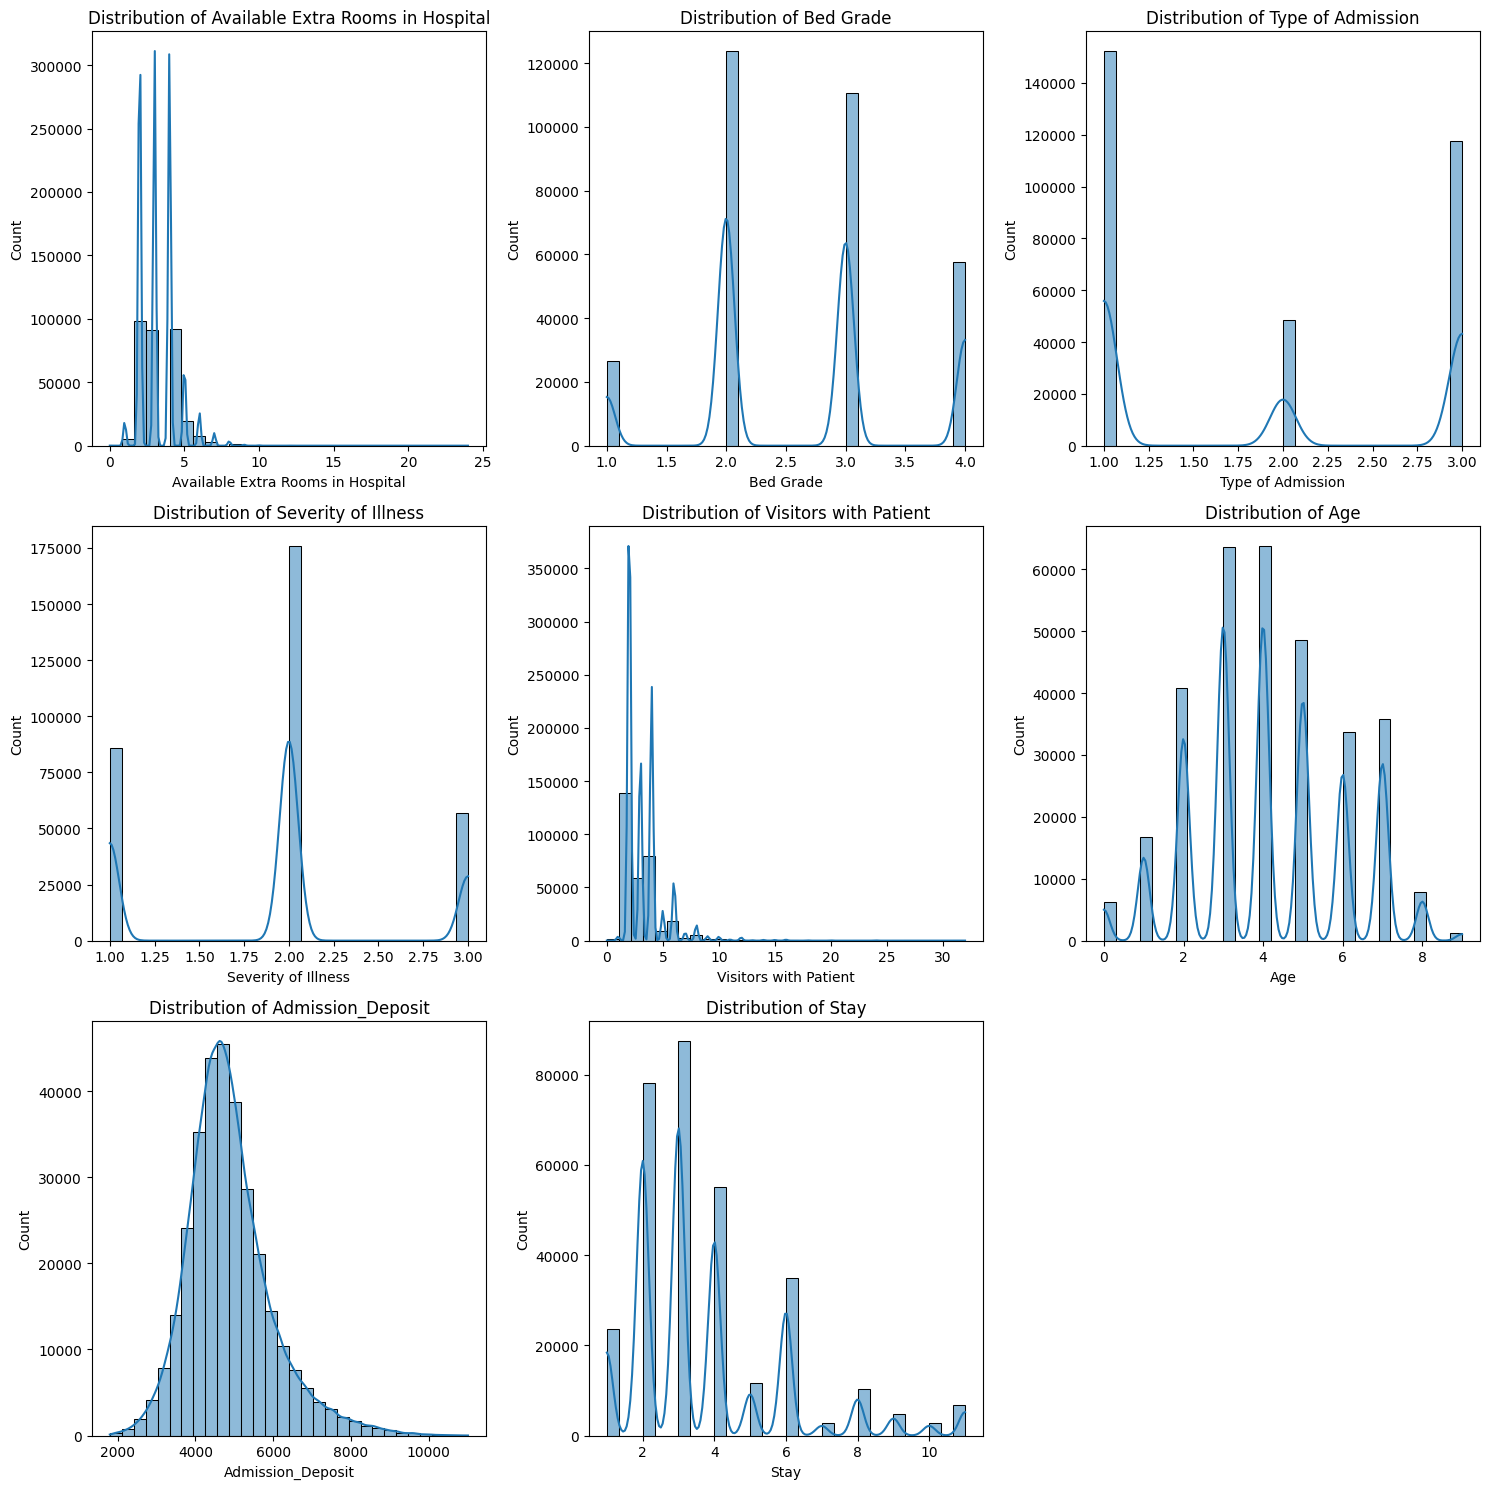

In [241]:
import math

# 5. Distribution of Numerical Variables
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features = len(num_cols)
rows = math.ceil(num_features / 3)
plt.figure(figsize=(15, 5 * rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(train_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

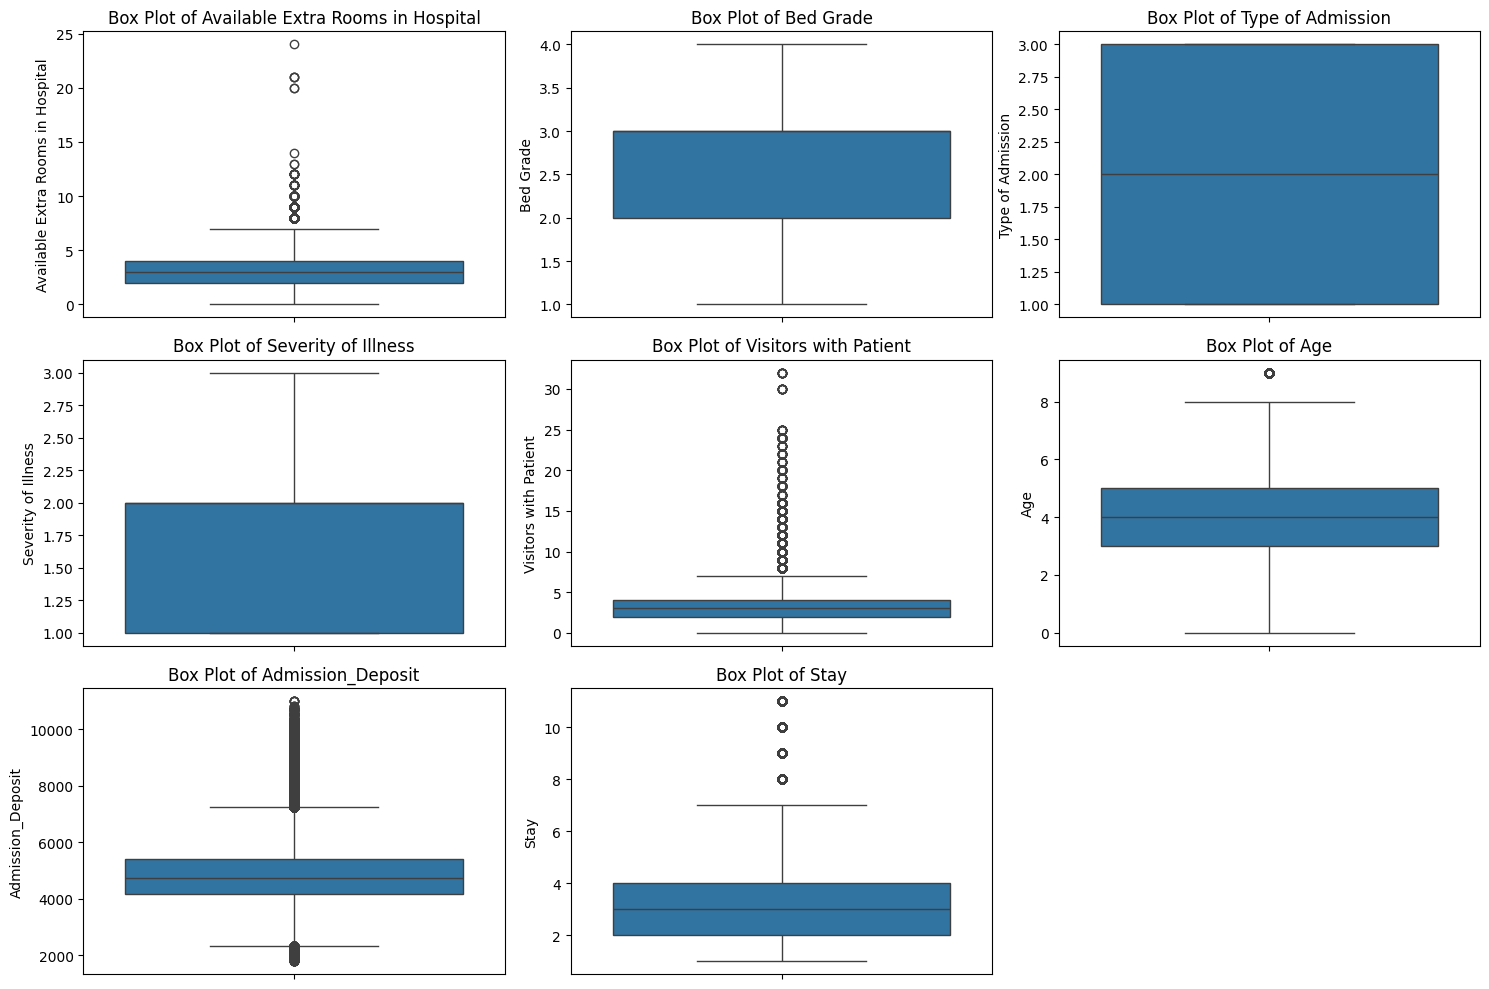

In [242]:
# 6. Box Plots for Outlier Detection
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=train_data[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


Value counts for Hospital_code:
Hospital_code
26    33076
23    26566
19    21219
6     20425
11    17328
14    17328
28    17137
27    14244
9     11510
29    11311
12    11297
32    10703
25     9834
10     9435
15     9257
21     8150
24     7992
3      7116
17     5501
5      5261
1      5249
13     5236
2      5102
30     5002
22     4277
31     3967
16     3671
8      3663
18     3630
20     1405
7      1306
4      1240
Name: count, dtype: int64

Value counts for Hospital_type_code:
Hospital_type_code
1    143425
2     68946
3     45928
5     24770
4     20389
6     10703
7      4277
Name: count, dtype: int64

Value counts for City_Code_Hospital:
City_Code_Hospital
1     55351
2     51809
6     46991
7     35463
3     31569
5     31105
9     26277
11    17137
4     13857
10     5249
13     3630
Name: count, dtype: int64

Value counts for Hospital_region_code:
Hospital_region_code
1    133336
2    122428
3     62674
Name: count, dtype: int64

Value counts for Department:
Departme

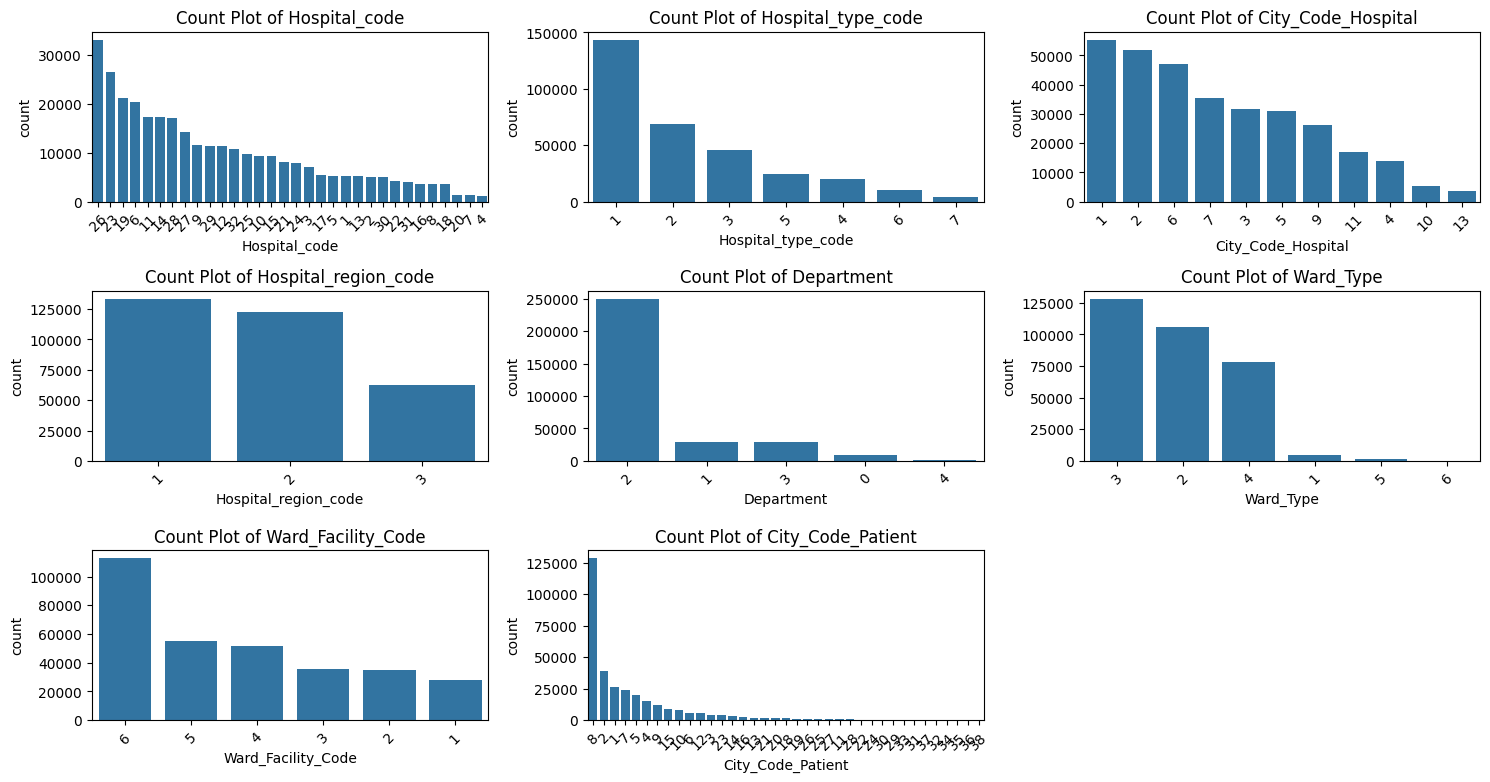

In [243]:
# 6. Count Plots for Categorical Variables
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    print(f"\nValue counts for {col}:")
    print(train_data[col].value_counts())
    plt.subplot(4, 3, i)
    sns.countplot(x=train_data[col], order=train_data[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col}')
plt.tight_layout()
plt.show()

## EDA Against Stay

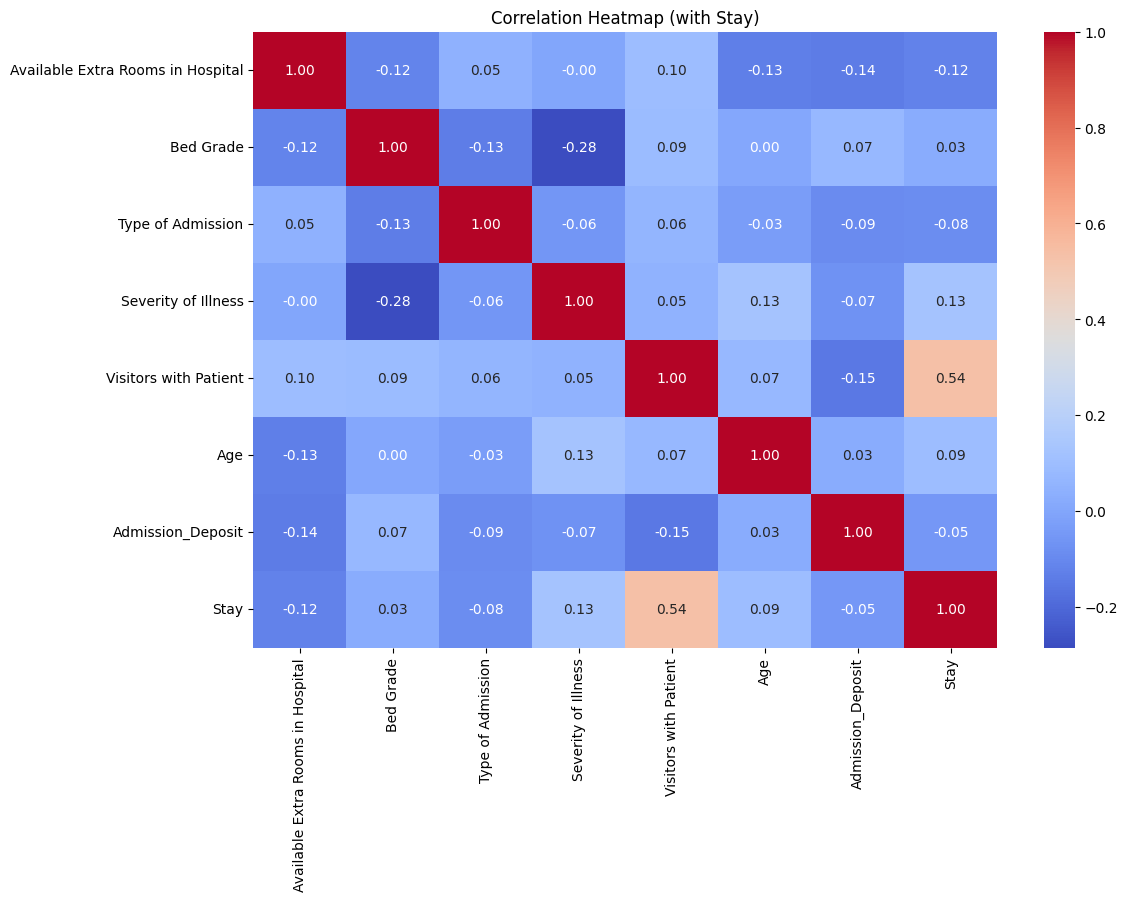

In [244]:
# Compute correlation matrix including Stay
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (with Stay)')
plt.show()

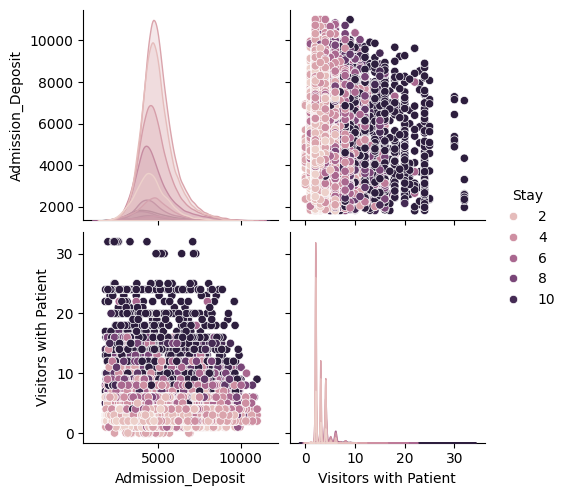

In [245]:
# 7. Pairplot for Top Features
selected_features = ['Admission_Deposit', 'Visitors with Patient', 'Stay']
sns.pairplot(train_data[selected_features], hue='Stay', diag_kind='kde')
plt.show()

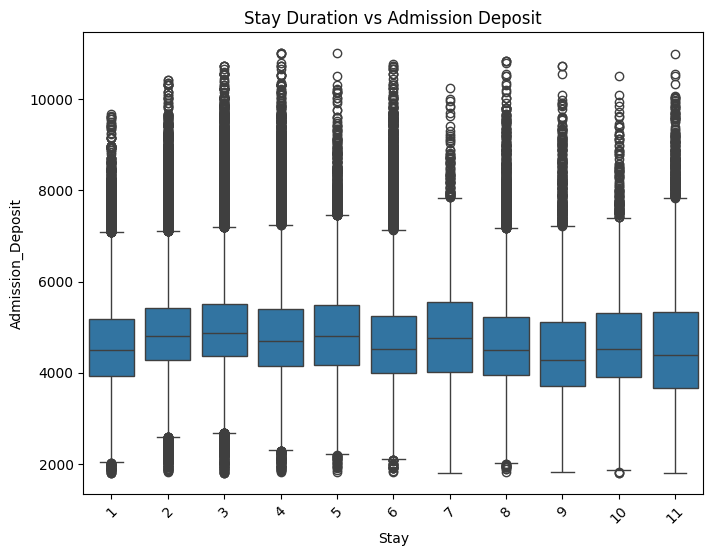

In [246]:
# 8. Box Plot of Stay vs Admission_Deposit
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['Stay'], y=train_data['Admission_Deposit'])
plt.xticks(rotation=45)
plt.title('Stay Duration vs Admission Deposit')
plt.show()

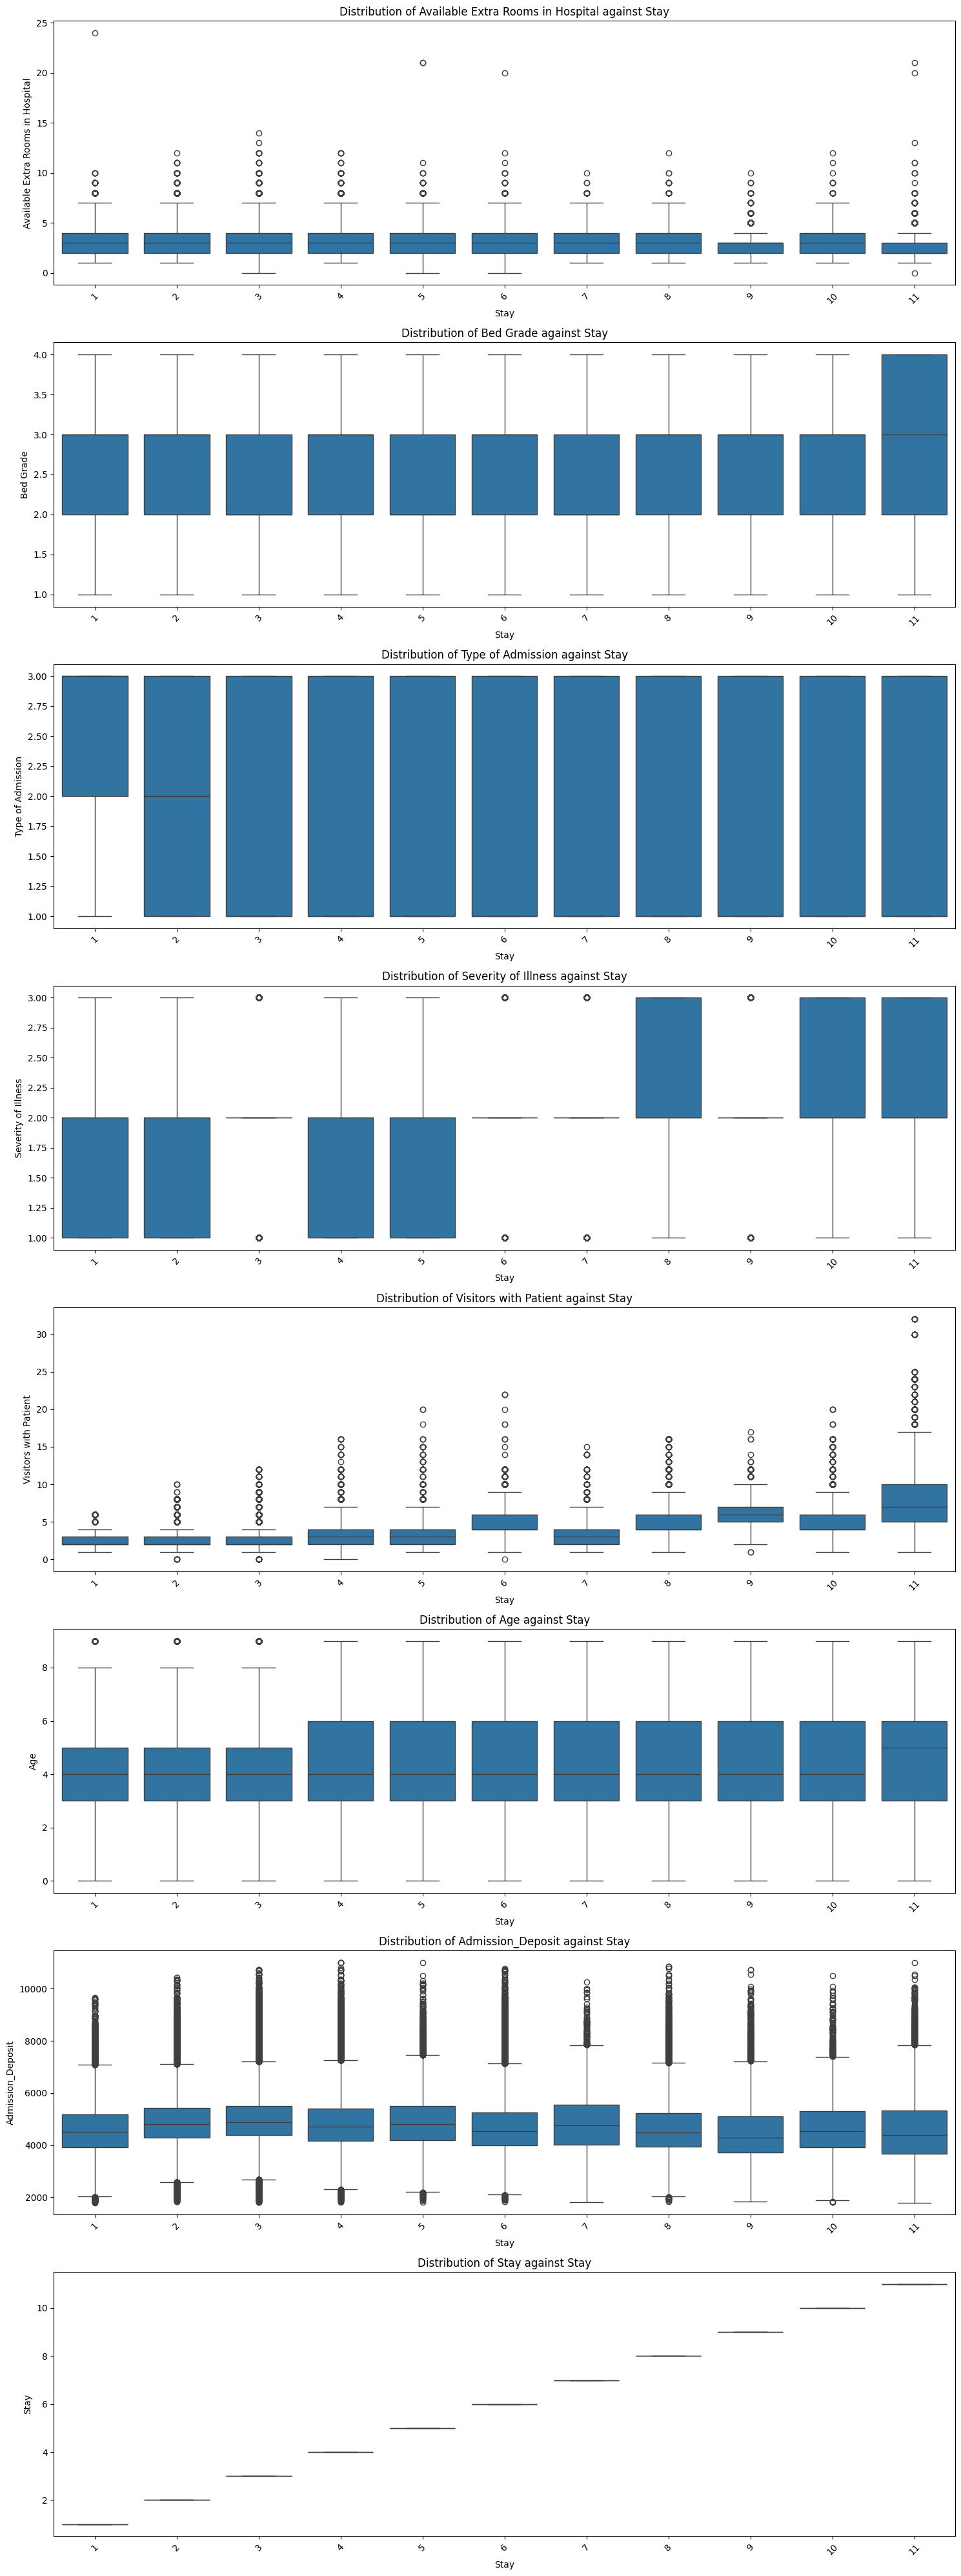

In [247]:
# Box plots of numerical variables against Stay
plt.figure(figsize=(15, 5 * len(num_cols)))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=train_data['Stay'], y=train_data[col])
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col} against Stay')
plt.tight_layout()
plt.show()

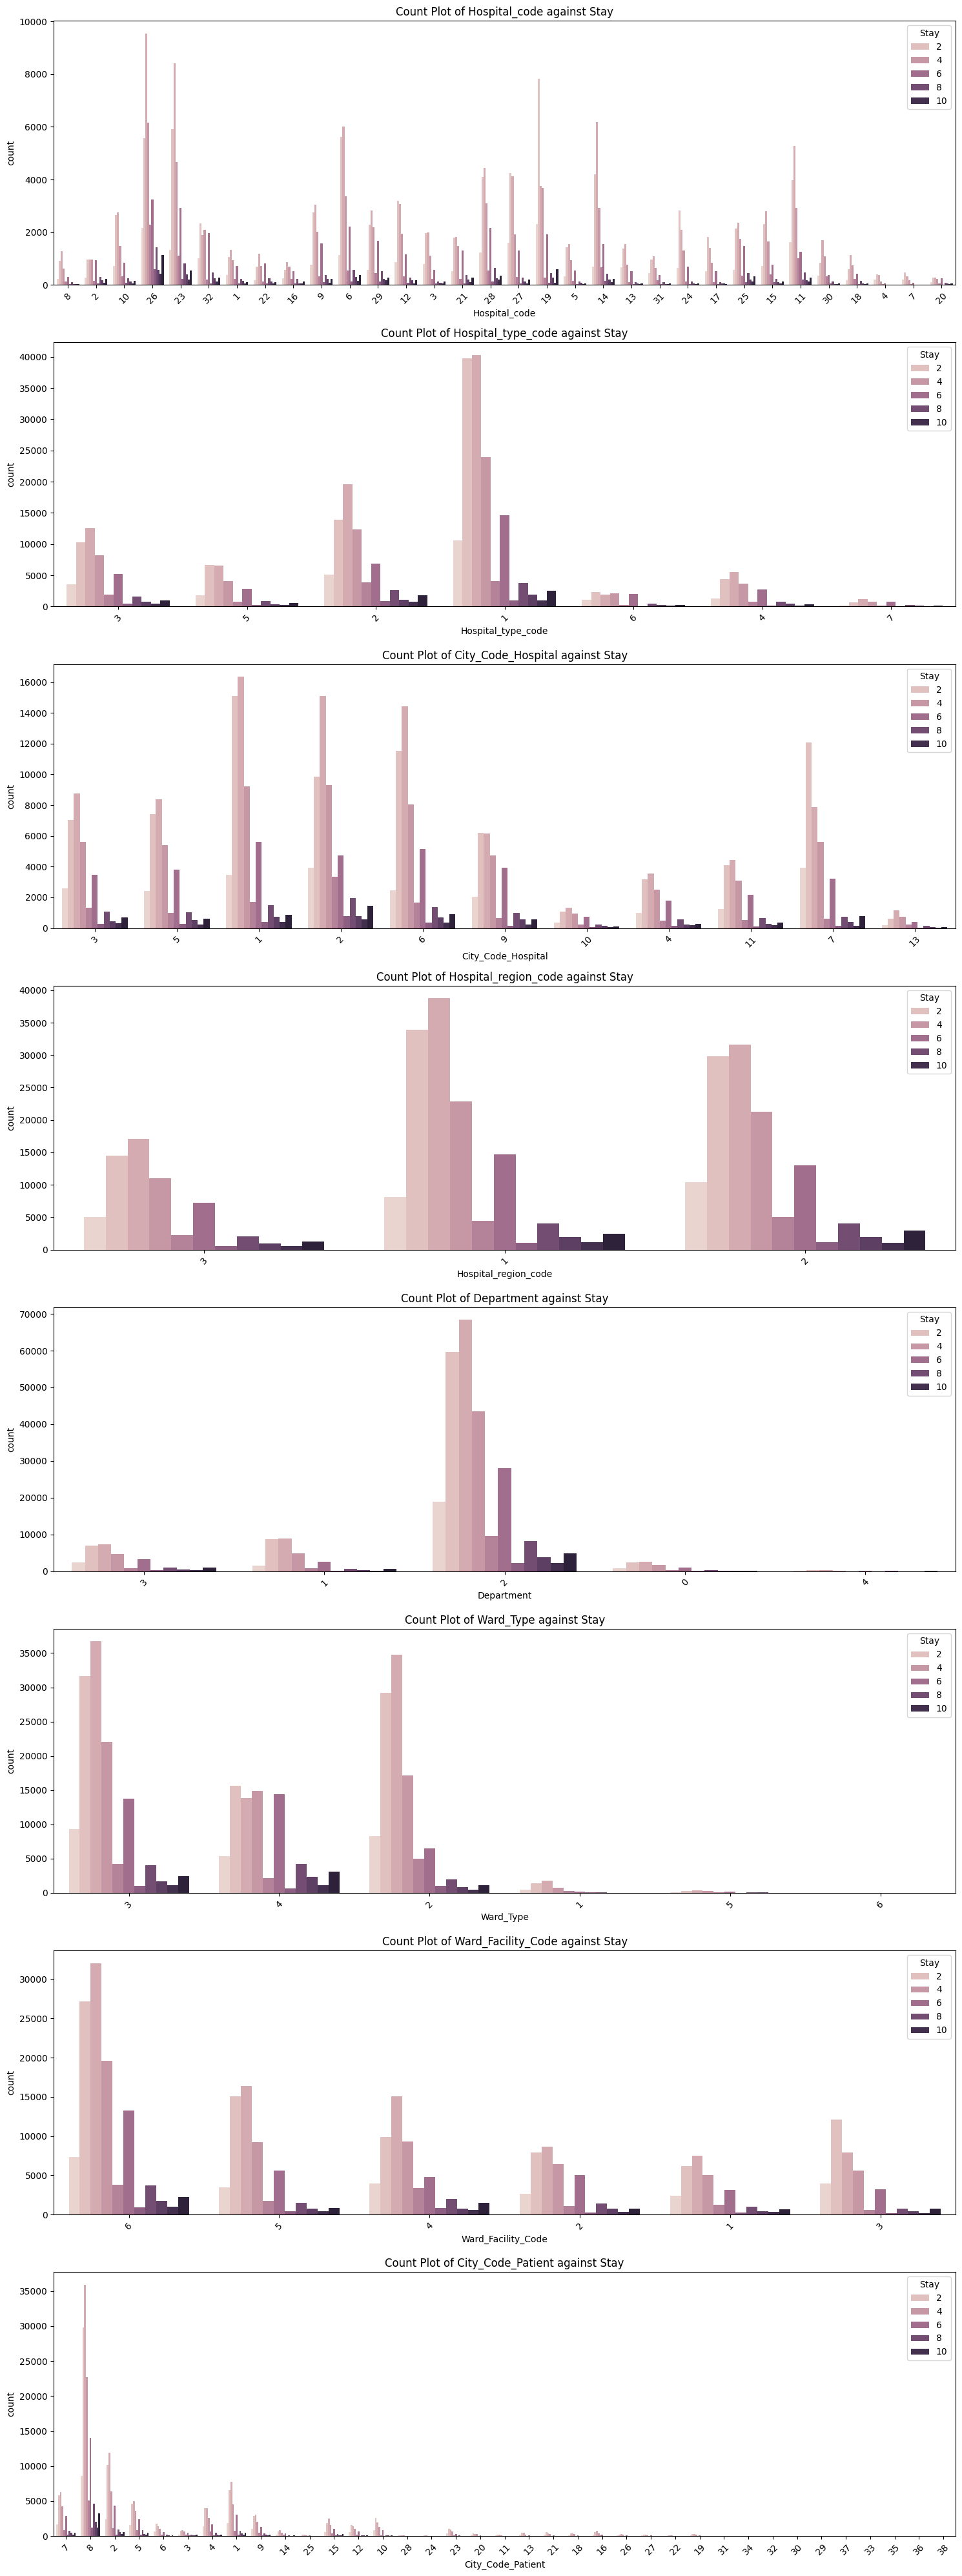

In [248]:
# Count plots of categorical variables against Stay
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()
plt.figure(figsize=(15, 5 * len(cat_cols)))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)
    sns.countplot(x=train_data[col], hue=train_data['Stay'])
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col} against Stay')
plt.tight_layout()
plt.show()

/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_69793/614400776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_69793/614400776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_69793/614400776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_69793/614400776.py:7: FutureWarning

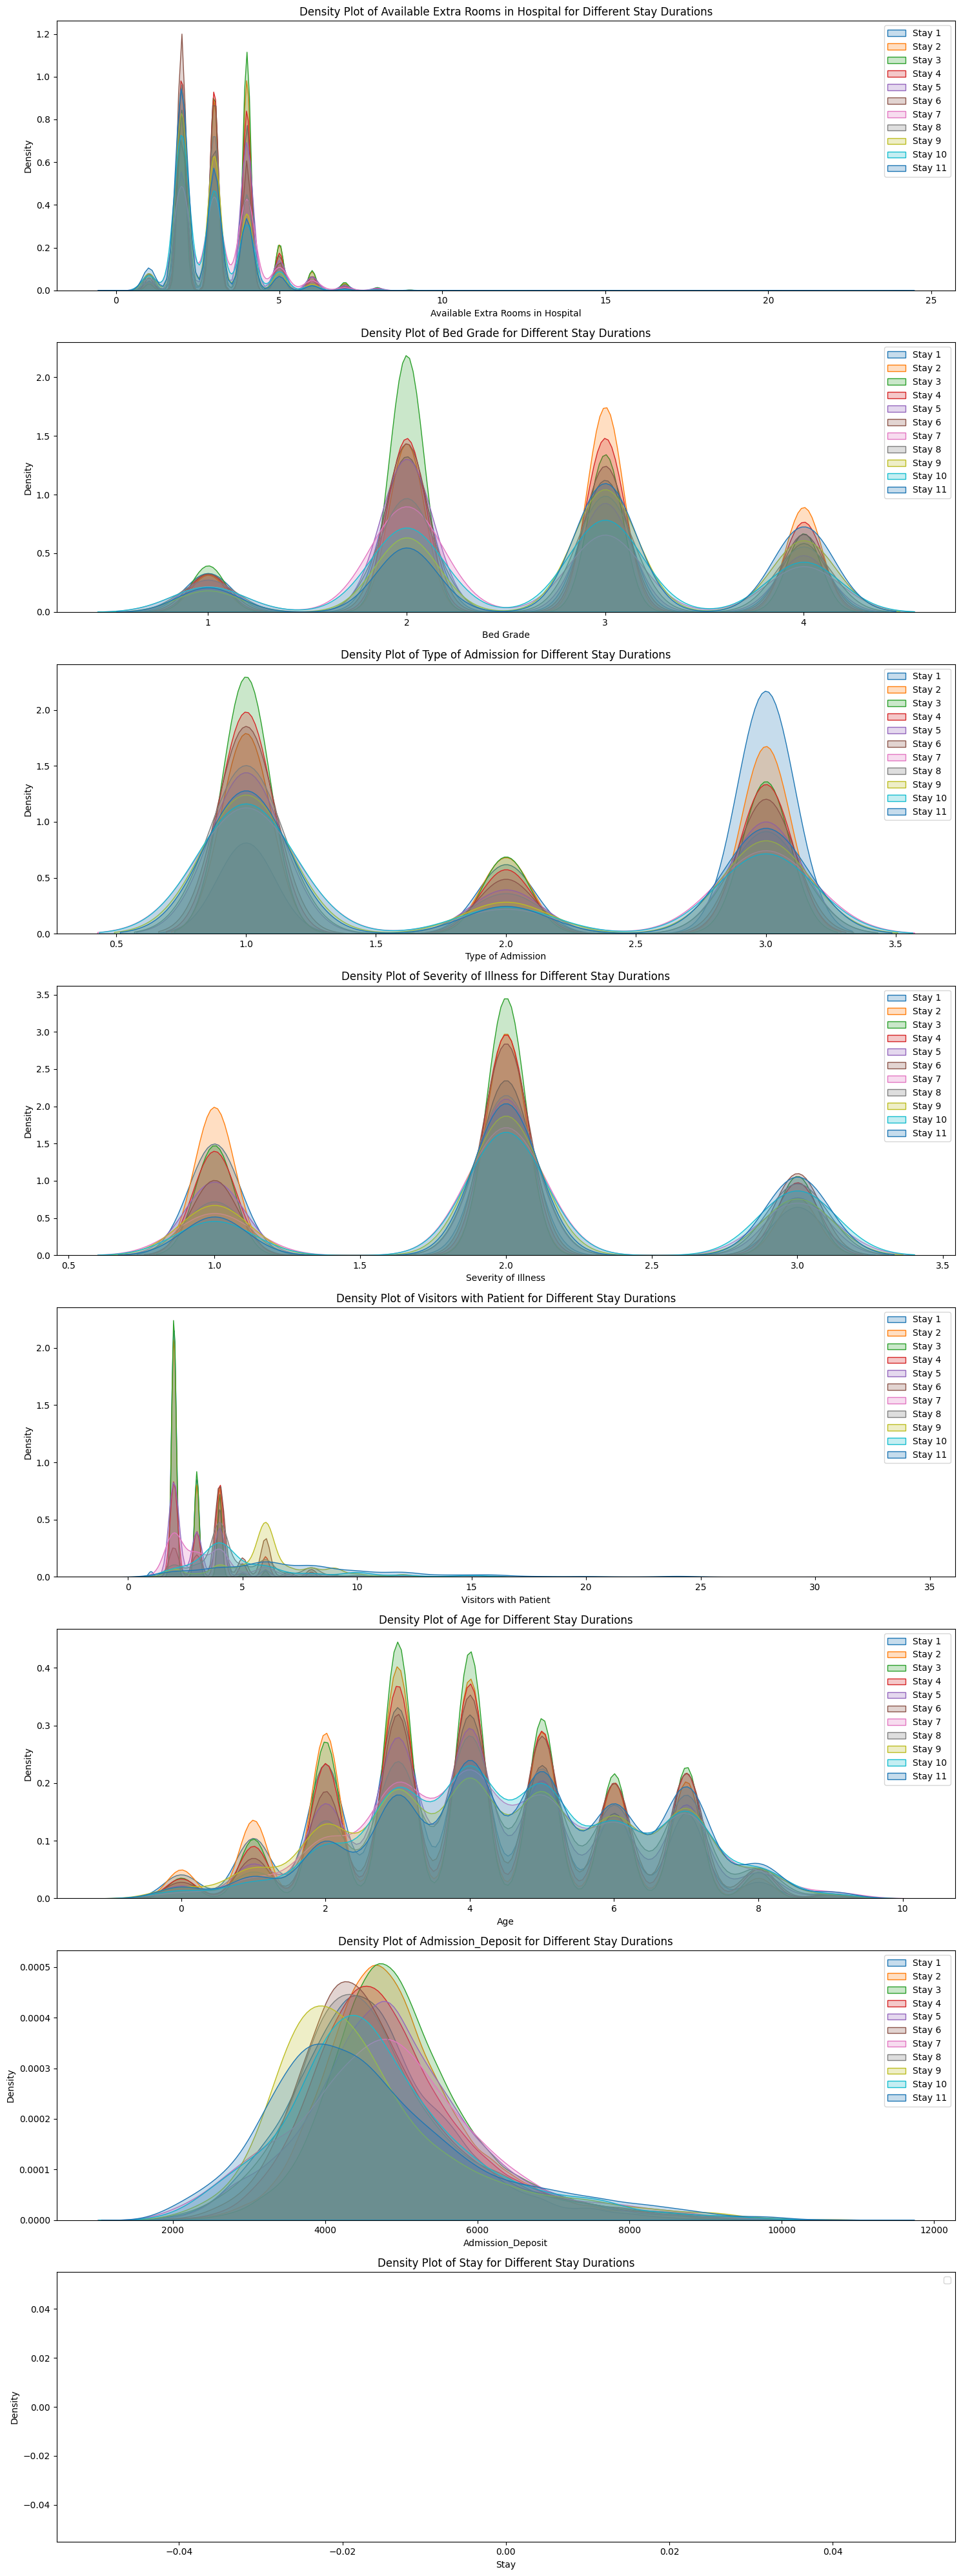

In [249]:
# KDE plots to visualize density distribution of numerical features by Stay
plt.figure(figsize=(15, 5 * len(num_cols)))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    for stay_val in sorted(train_data['Stay'].unique()):
        subset = train_data[train_data['Stay'] == stay_val]
        sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
    plt.legend()
    plt.title(f'Density Plot of {col} for Different Stay Durations')
plt.tight_layout()
plt.show()